В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде __класифікувати__ товари із датасету `fasion_mnist`.

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно __91%__. Точність вашої моделі повинна бути `не нижчою` за цей показник. Щоб досягти таких значень вам знадобиться `поекспериментувати з гіперпараметрами мережі`:

- кількість шарів;

- кількість нейронів;

- функції активації;

- кількість епох;

- розмір батчу;

- вибір оптимізатора;

- різні техніки регуляризації і т.д.

Використайте вивчені `техніки виявлення проблем навчання` нейронної мережі, і потім `поекспериментуйте`.

Рішення оформіть у вигляді окремого ноутбука.

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.datasets import fashion_mnist
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras import metrics
from keras import optimizers


2023-09-01 20:51:31.343316: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 20:51:31.365231: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 20:51:31.542072: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 20:51:31.543130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 20:51:32.419661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### __Dataset__

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.dtype, x_train[0].shape

(dtype('uint8'), (28, 28))

In [3]:
NUM_FEATURES = x_train[0].shape[0] * x_train[0].shape[1]

In [4]:
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# each sample (28x28) to 1x784
x_train, x_test = x_train.reshape([-1, NUM_FEATURES]), x_test.reshape([-1, NUM_FEATURES])
print(min(x_train.min(), x_test.min()))
maximum = max(x_train.max(), x_test.max()) # np.max([x_train.max(), x_test.max()]) 
maximum

0.0


255.0

In [5]:
# Normalize (min = 0)
x_train, x_test = x_train / maximum, x_test / maximum

In [6]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [7]:
max(y_train.max(), y_test.max()), min(y_train.min(), y_test.min())

(9, 0)

In [8]:
NUM_CLASSES = len(set(np.concatenate((y_train, y_test), axis=0)))
NUM_CLASSES

10

In [9]:
y_true = tf.one_hot(y_train, depth=NUM_CLASSES).numpy()
y_truev = tf.one_hot(y_test, depth=NUM_CLASSES).numpy()
y_true.shape, y_truev.shape

((60000, 10), (10000, 10))

### __Model__

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy

In [10]:
# number of hidden layers
n_layers = [2]  # 1, 2
n_of_neurons = [256, 64] # [[2**el for el in range(1, 9)] for _ in n_layers]  # 7

activations = ['relu', 'softmax']  # 'mish',

optimizators = [optimizers.legacy.Adam]  # 3
learning_rates = [0.001]  # 2
n_epoch = 100  # max limit
batch_sizes = [2**el for el in range(7, 10)]  # 3



In [11]:
n_hiddens_ = []  # list of different (by number) layers for different models
bundle_activations  = []  # list of various feature sets of activations of all layers for different models
for s in n_layers:
    for el in list(itertools.product(n_of_neurons, repeat=s)):
        n_hidden_i = []
        n_hidden_i.append(NUM_FEATURES)
        n_hidden_i.extend(el)
        n_hidden_i.append(NUM_CLASSES)

        n_hiddens_.append(n_hidden_i)

    for el in list(itertools.product(activations[:-1], repeat=s)):
        activat = []
        activat.extend(el)
        activat.append(activations[-1])

        bundle_activations.append(activat)
    

In [12]:
len(n_hiddens_), len(bundle_activations)

(4, 1)

In [13]:
# matching layers with models
cx = 0  # number of options
for set_layers in n_hiddens_:  # 584
    for act in bundle_activations:  # 39
        if len(set_layers) == (len(act) + 1):
            cx+=1

cx

4

In [15]:
def create_NN(n_hidden_: list, activation: list, optimizer=optimizers.SGD, learning_rate=0.1) -> Sequential:
    model = Sequential(name=f'''m-{''.join(map(str, [f'{i}-' for i in n_hidden_[1:-1]]))}{''.join(map(str, [f'{a}-' for a in activation[:-1]]))}{optimizer.__name__}-{learning_rate}''')
    n_layers = len(n_hidden_)
    for layer in range(1, n_layers):
        model.add(Dense(n_hidden_[layer], activation=activation[layer-1], input_shape=(n_hidden_[layer-1],)))

    model.compile(
                  optimizer=optimizer(learning_rate=learning_rate), # legacy
                  loss=losses.CategoricalCrossentropy(),  # 'categorical_crossentropy' losses.binary_crossentropy,
                  metrics=['accuracy', metrics.CategoricalAccuracy()]  # metrics.BinaryAccuracy()  CategoricalAccuracy()
                  )

    return model

In [16]:
models = []  # 9216 models # !!! more then 32 GB RAM!!!!, ... try 1260 = 28sec
for set_layers in n_hiddens_:  # 584
    for act in bundle_activations:  # 39
        if len(set_layers) == (len(act) + 1):  # 1024  -> 210
            for opt in optimizators:  # 3
                for lr in learning_rates:  # 2
                    models.append(create_NN(n_hidden_=set_layers, activation=act, optimizer=opt, learning_rate=lr))

In [17]:
models[0].name  # model(m)-n_layer_1-...-activ_fun_layer_1-...-optimizator-learning_rate:

'm-256-256-relu-relu-Adam-0.001'

### __Training__

In [18]:
history = {}  # 27648 = 38+ days training
lucky_numbers = np.random.randint(1, len(models), size=5)
for num, model in enumerate(models):
    if num in lucky_numbers:
        for bs in batch_sizes:  # 3
            history[f'{model.name}({bs})'] = model.fit(
                                                        x_train,
                                                        y_true,
                                                        epochs=100,
                                                        batch_size=bs,
                                                        validation_data=(x_test, y_truev)
                                                        )

Epoch 1/100
469/469 [==============================] - 2s 3ms/step - loss: 0.5307 - accuracy: 0.8147 - categorical_accuracy: 0.8147 - val_loss: 0.4309 - val_accuracy: 0.8446 - val_categorical_accuracy: 0.8446
Epoch 2/100
469/469 [==============================] - 1s 3ms/step - loss: 0.3788 - accuracy: 0.8634 - categorical_accuracy: 0.8634 - val_loss: 0.3868 - val_accuracy: 0.8630 - val_categorical_accuracy: 0.8630
Epoch 3/100
469/469 [==============================] - 1s 3ms/step - loss: 0.3389 - accuracy: 0.8755 - categorical_accuracy: 0.8755 - val_loss: 0.3777 - val_accuracy: 0.8636 - val_categorical_accuracy: 0.8636
Epoch 4/100
469/469 [==============================] - 1s 3ms/step - loss: 0.3123 - accuracy: 0.8863 - categorical_accuracy: 0.8863 - val_loss: 0.3521 - val_accuracy: 0.8731 - val_categorical_accuracy: 0.8731
Epoch 5/100
469/469 [==============================] - 1s 3ms/step - loss: 0.2911 - accuracy: 0.8925 - categorical_accuracy: 0.8925 - val_loss: 0.3509 - val_accurac

### __Error Analysis__

In [204]:
# print(history[0].history.keys())
""" 
loss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи
val_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи
accuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи
val_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи
"""

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


' \nloss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи\nval_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи\naccuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи\nval_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи\n'

In [19]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    axs[1].grid()
    plt.show()


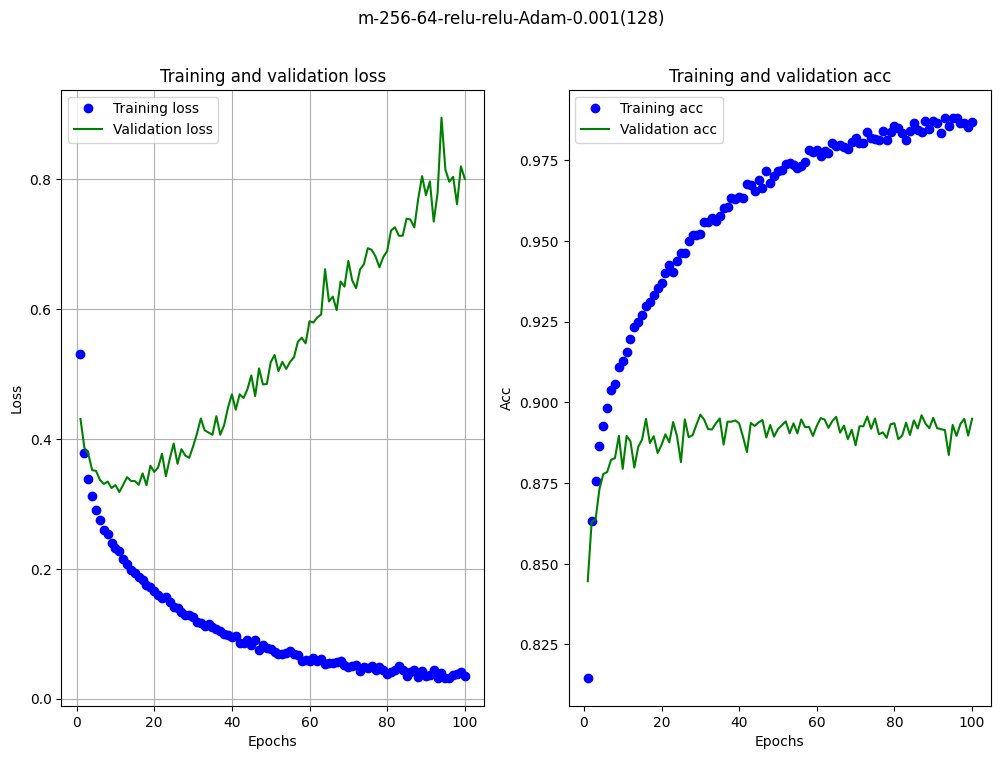

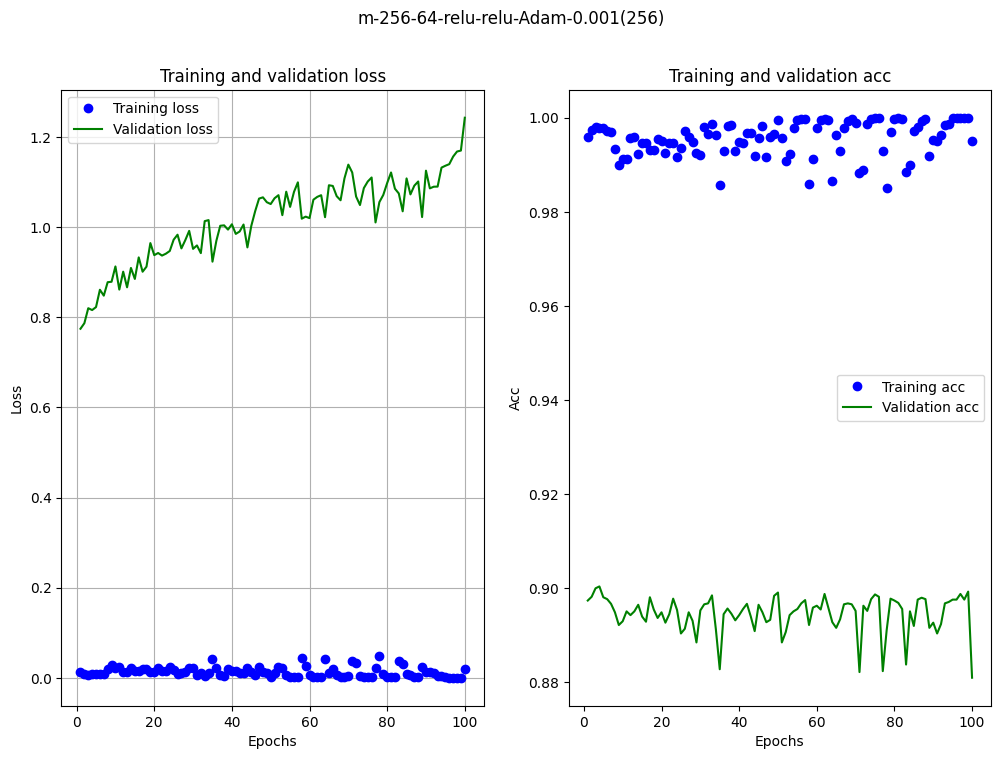

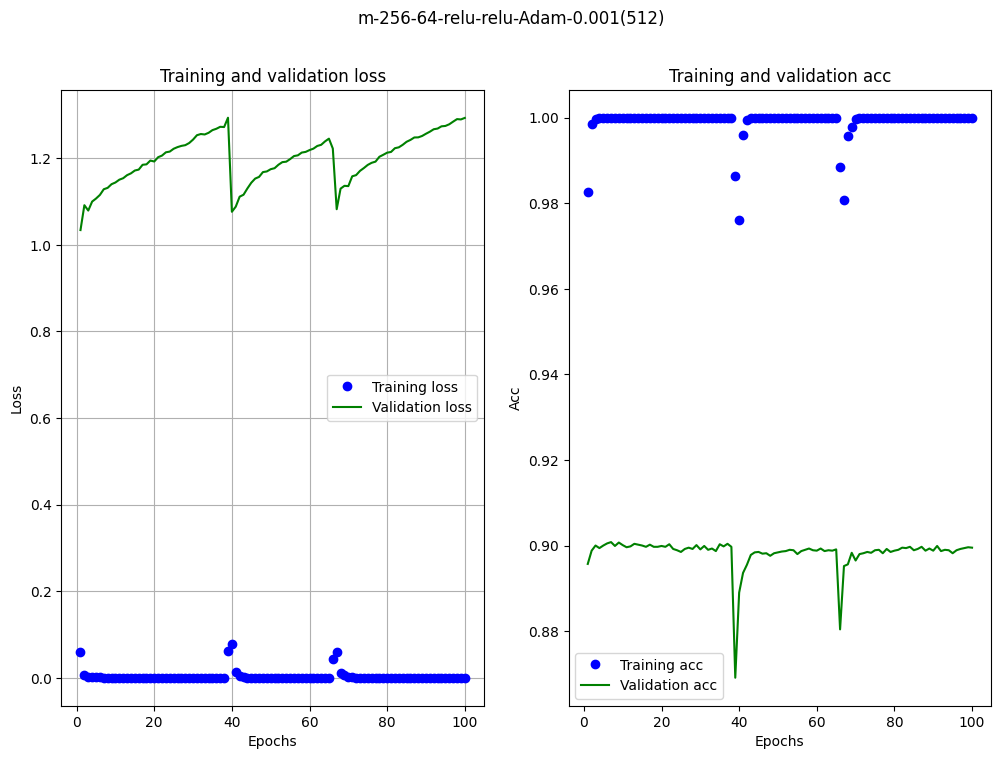

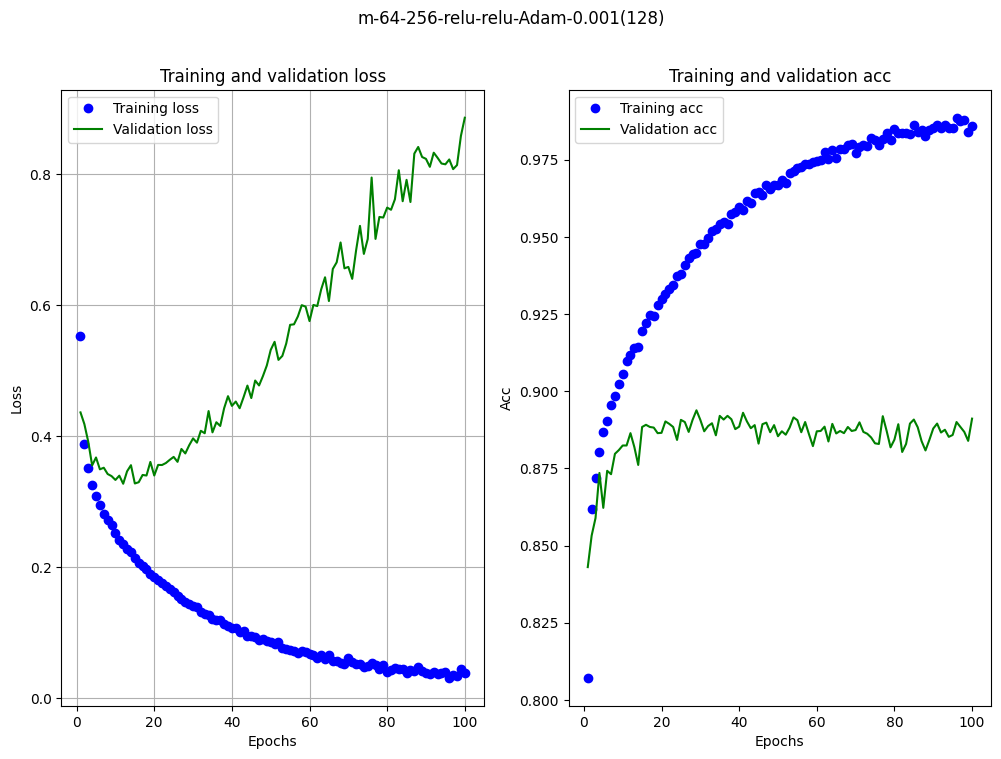

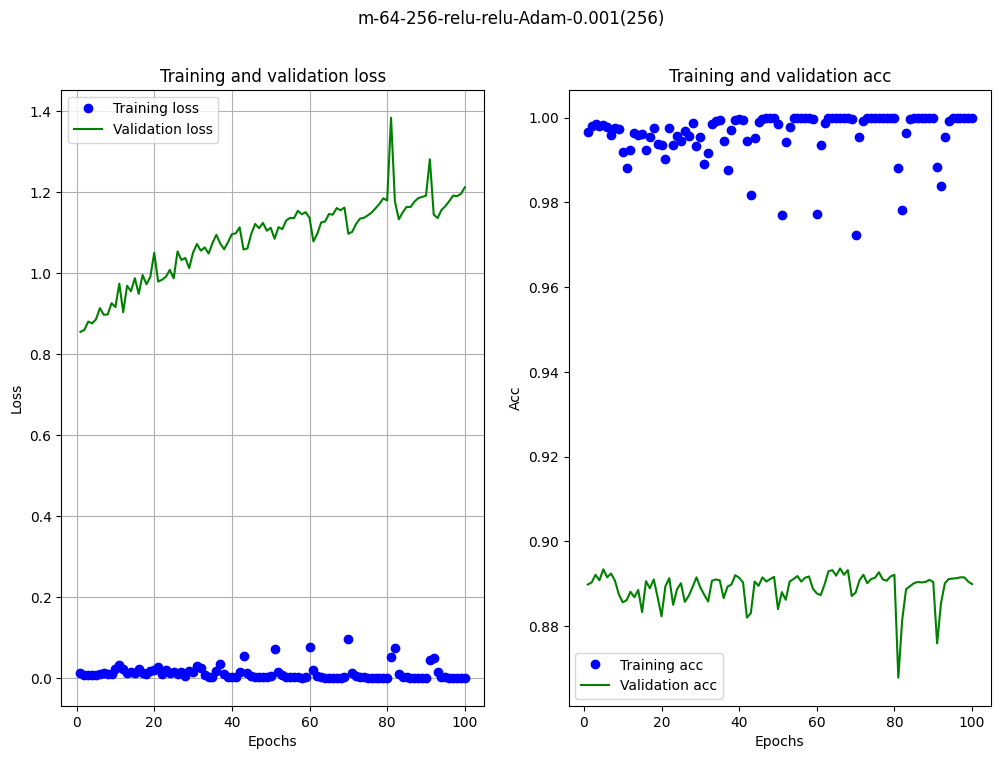

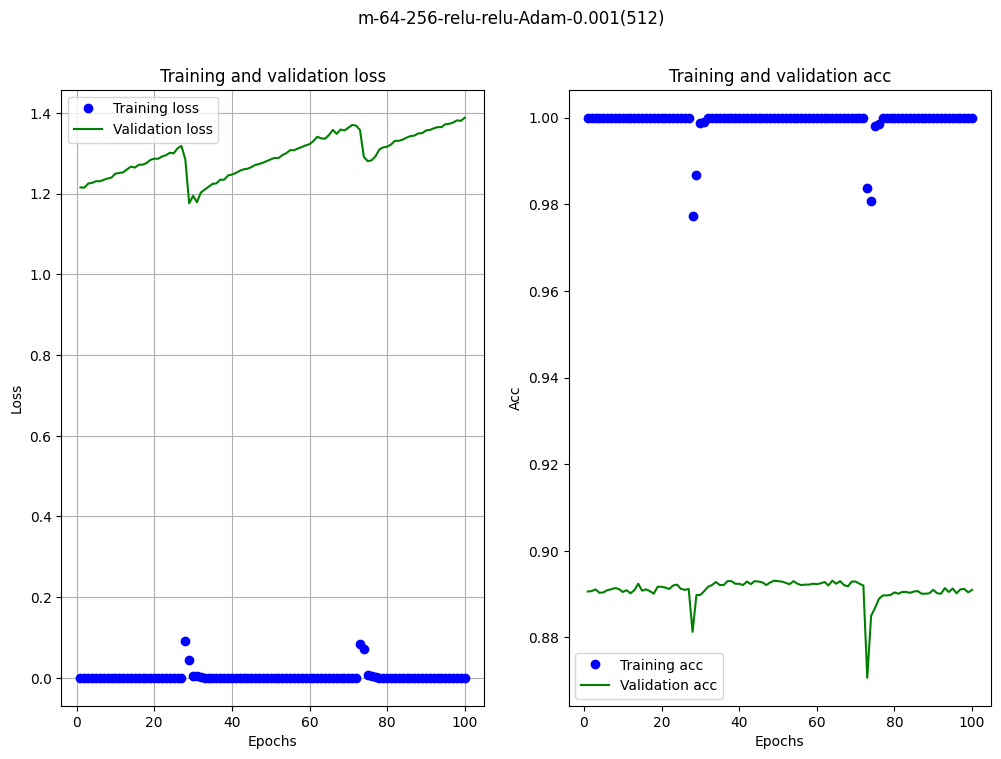

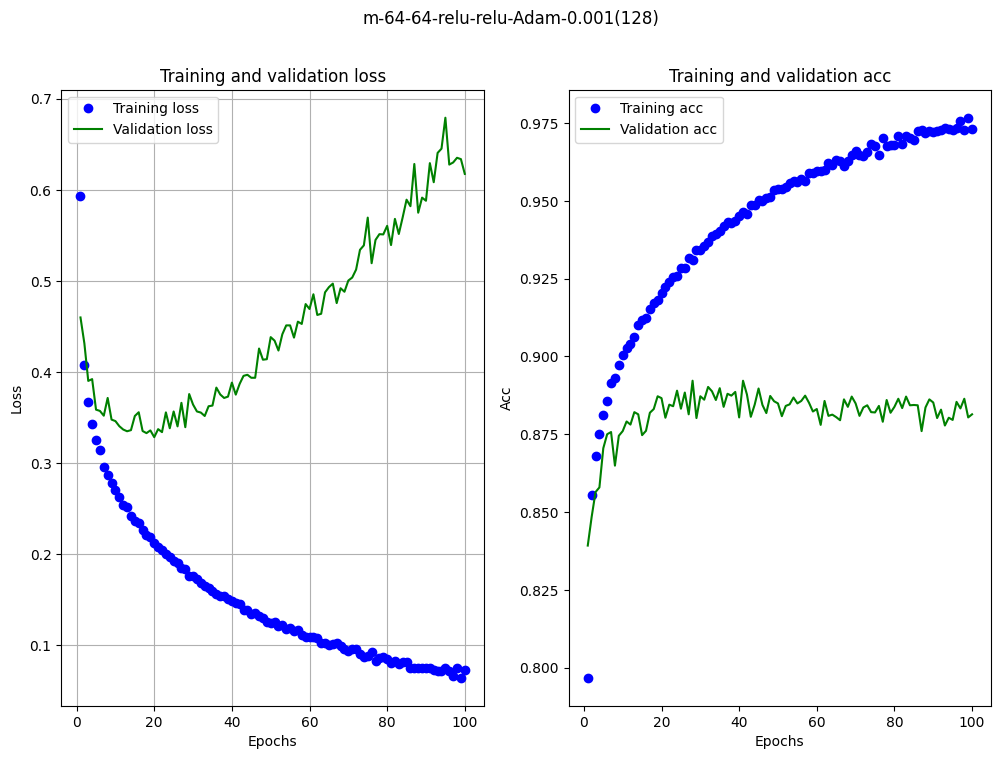

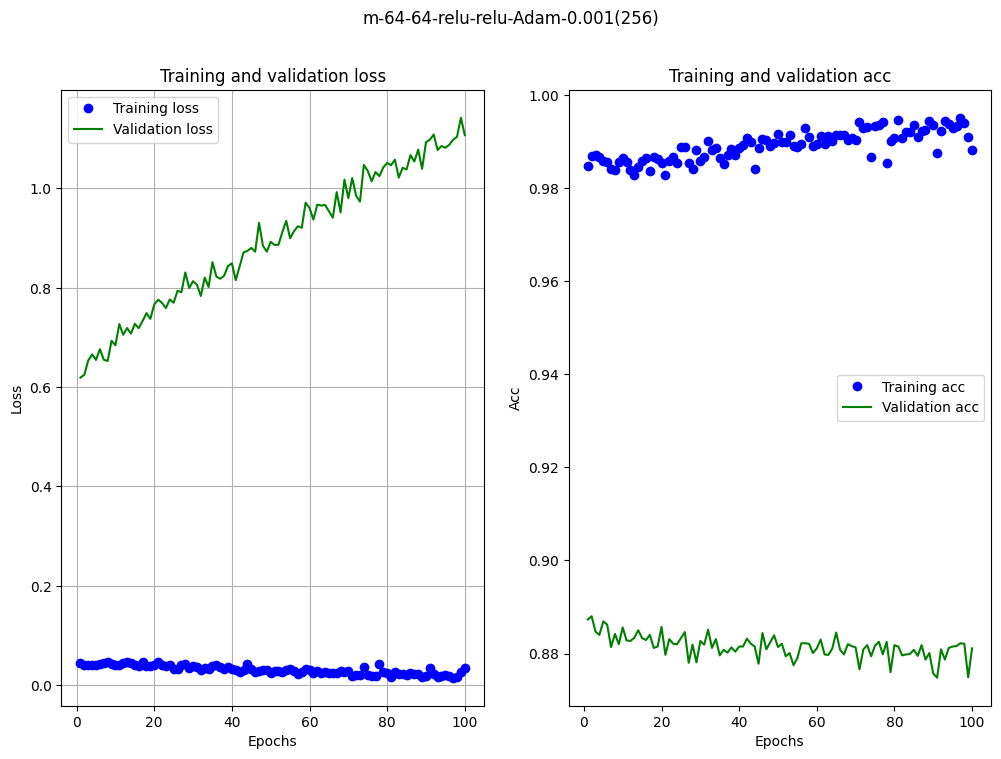

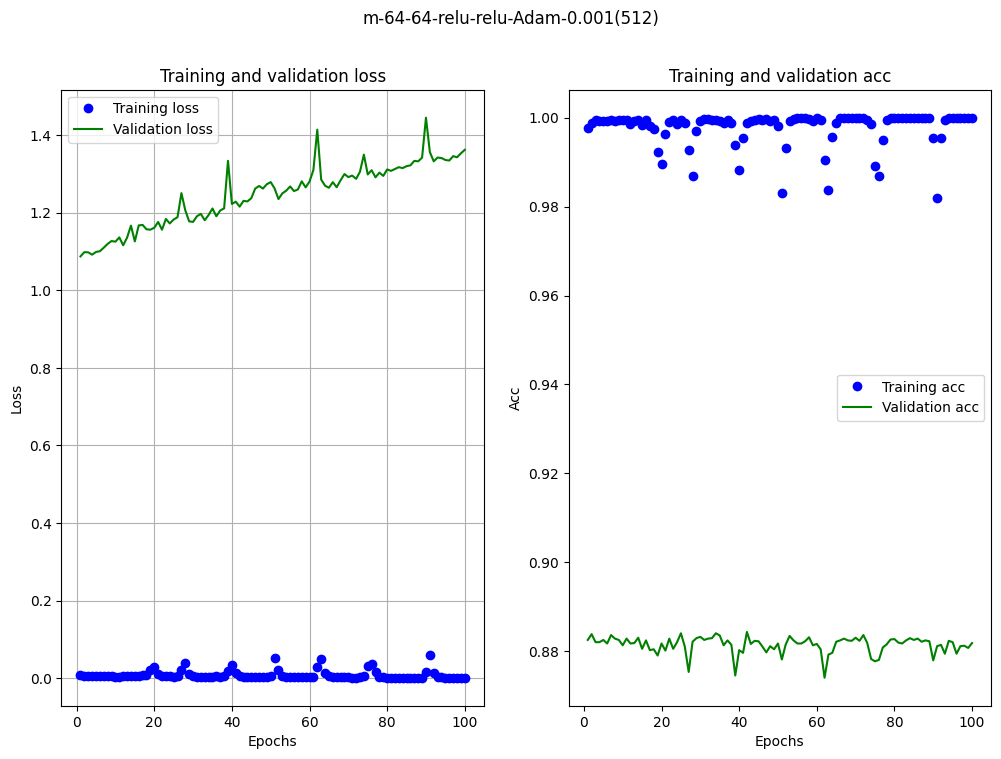

In [20]:
for model in history:
    history_dict = history[model].history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=model)
